# CLAHE Tutorial with NVIDIA DALI
Welcome to this hands-on tutorial!
In this notebook, you'll learn how to use Contrast Limited Adaptive Histogram Equalization (CLAHE) with NVIDIA DALI for image enhancement.

## Introduction to CLAHE
This notebook demonstrates how to use **CLAHE (Contrast Limited Adaptive Histogram Equalization)** with DALI's dynamic API for image preprocessing.

CLAHE is a powerful technique that improves contrast in images without overamplifying noise, making it particularly useful for medical imaging, surveillance, and low-contrast photography.

## Using Real Medical Imaging Data
This tutorial includes demonstrations with **real knee MRI slices** from the DALI_extra repository, which perfectly showcase CLAHE's effectiveness on low-contrast medical images.

**To use the MRI data:**
```bash
# Clone DALI_extra (requires git-lfs)
git clone https://github.com/NVIDIA/DALI_extra.git
cd DALI_extra && git lfs pull

# Set environment variable
export DALI_EXTRA_PATH=/path/to/DALI_extra
```

The MRI data will be at: `$DALI_EXTRA_PATH/db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001/`

The data is organized in a nested structure:
- `STU00001/` - Patient study directory
- `SER00001/`, `SER00002/`, ... - Series directories (different MRI sequences)
- `0.npy`, `1.npy`, ... - Individual 2D slice files

---

## Required Imports
Let's start by importing the necessary modules.

In [1]:
import glob
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import nvidia.dali.experimental.dynamic as ndd
import nvidia.dali.types as types

## Parameter Comparison
Let's demonstrate how different CLAHE parameters affect the results using synthetic images.

> **Try it yourself:** Experiment with different values for `tiles_x`, `tiles_y`, and `clip_limit` to see their impact.

In [2]:
# Create a test image with poor contrast (narrow intensity range)
base_image = ndd.random.uniform(
    range=(80, 120), shape=(256, 256, 1), dtype=types.UINT8
)

# Different CLAHE configurations to compare:
# 1. Default settings - balanced approach
clahe_default = ndd.clahe(base_image, tiles_x=8, tiles_y=8, clip_limit=2.0)

# 2. Aggressive enhancement - more contrast, more local adaptation
clahe_aggressive = ndd.clahe(base_image, tiles_x=16, tiles_y=16, clip_limit=4.0)

# 3. Gentle enhancement - subtle improvement
clahe_gentle = ndd.clahe(base_image, tiles_x=4, tiles_y=4, clip_limit=1.0)

In [3]:
configurations = [
    ("Base image (no CLAHE)", base_image),
    ("Default CLAHE (8x8, limit=2.0)", clahe_default),
    ("Aggressive CLAHE (16x16, limit=4.0)", clahe_aggressive),
    ("Gentle CLAHE (4x4, limit=1.0)", clahe_gentle),
]

print("PARAMETER COMPARISON RESULTS")
print("=" * 60)

for name, tensor in configurations:
    img = np.asarray(tensor)
    std_dev = np.std(img)
    print(f"{name}")
    print(f"   Standard deviation (contrast measure): {std_dev:.2f}")
    print()

print(" Key Takeaways:")
print("   - Higher std dev = more contrast")
print("   - More tiles (16x16) = more local adaptation")
print("   - Higher clip limit = stronger enhancement")
print("   - Choose parameters based on your image type and requirements!")

PARAMETER COMPARISON RESULTS
Base image (no CLAHE)
   Standard deviation (contrast measure): 11.55

Default CLAHE (8x8, limit=2.0)
   Standard deviation (contrast measure): 31.63

Aggressive CLAHE (16x16, limit=4.0)
   Standard deviation (contrast measure): 49.54

Gentle CLAHE (4x4, limit=1.0)
   Standard deviation (contrast measure): 21.25

 Key Takeaways:
   - Higher std dev = more contrast
   - More tiles (16x16) = more local adaptation
   - Higher clip limit = stronger enhancement
   - Choose parameters based on your image type and requirements!


## Practical Applications & Next Steps
Where can you use CLAHE?
- **Medical Imaging** (Best use case): Enhance X-rays, CT scans, MRI images
  - Reveals subtle tissue boundaries and pathological structures
  - Improves diagnostic visualization without changing underlying data
  - Essential for low-contrast modalities like MRI and ultrasound
- **Computer Vision**: Improve object detection in low-contrast scenes
- **Photography**: Enhance details in shadows and highlights
- **Security**: Improve visibility in surveillance footage
- **Astronomy**: Enhance celestial object visibility
- **Microscopy**: Reveal cellular structures in biological samples

**Parameter Tuning Guidelines:**
- **Medical scans (MRI, CT)**: tiles_x/y = 8-12, clip_limit = 2.0-3.5
  - Higher clip_limit for very low-contrast tissue boundaries
  - Moderate tile size to preserve spatial relationships
- **X-rays**: tiles_x/y = 6-10, clip_limit = 2.0-3.0
- **Natural photos**: tiles_x/y = 6-10, clip_limit = 2.0-3.0
- **Low-light images**: tiles_x/y = 10-16, clip_limit = 3.0-4.0
- **High-noise images**: tiles_x/y = 4-8, clip_limit = 1.0-2.0

**GPU vs CPU Implementation:**
- **GPU**: Only supports `luma_only=True` (default) - processes luminance channel in LAB color space
  - Fast GPU acceleration
  - Preserves color relationships
  - Ideal for most use cases
- **CPU**: Supports both `luma_only=True` and `luma_only=False`
  - The CPU version just makes a call to OpenCV's CLAHE
  - `luma_only=False` processes each RGB channel independently
  - Slower but offers per-channel processing option

## DALI CLAHE vs OpenCV CLAHE on Medical Imaging (Knee MRI)
This section demonstrates CLAHE on **real low-contrast medical imaging data** - knee MRI slices from the DALI_extra repository. Medical imaging is where CLAHE truly shines, as these images often have naturally low contrast that benefits significantly from adaptive histogram equalization.

The knee MRI slices (`db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001/`) are perfect for demonstrating CLAHE because:
- **Low local contrast**: MRI data typically has subtle tissue boundaries
- **Grayscale**: Single-channel data ideal for CLAHE
- **Real-world clinical data**: Demonstrates practical medical imaging applications
- **Multiple sequences**: 15 different series (SER00001-SER00015) available for experimentation

> **Try it yourself:** Run the next cells to see side-by-side results on actual medical imaging data.

Loading knee MRI slice from DALI_extra...
Found 5 MRI slices in STU00001/SER00001/
MRI slice loaded: 0.npy
Original shape: (512, 512), dtype: uint8
Final shape for processing: (512, 512, 1)

Image statistics:
Mean: 5.3, Std: 19.7
Min: 0, Max: 255

Note: Notice the low contrast in this medical image - perfect for CLAHE.


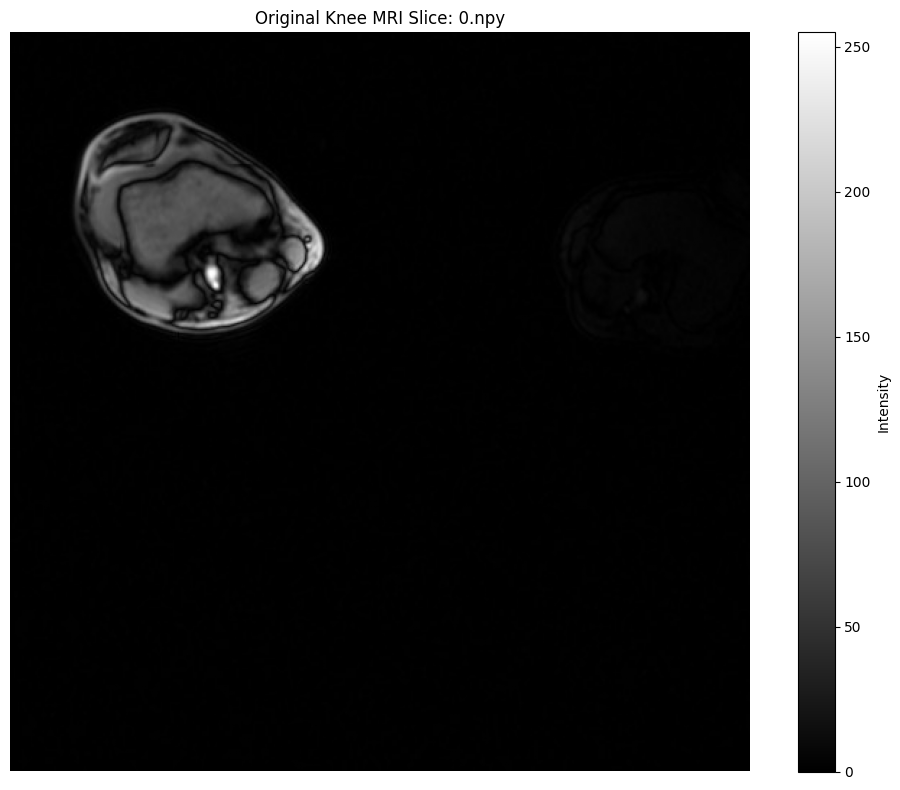

In [4]:
# Load knee MRI slice from DALI_extra
dali_extra_path = Path(os.environ["DALI_EXTRA_PATH"])
mri_base_path = dali_extra_path / "db" / "3D" / "MRI" / "Knee" / "npy_2d_slices"
mri_path = mri_base_path / "STU00001" / "SER00001"

npy_files = sorted(mri_path.glob("*.npy"))
print(f"Loading knee MRI slice from DALI_extra...")
print(f"Found {len(npy_files)} MRI slices in STU00001/SER00001/")

# Load the first MRI slice
mri_data = np.load(npy_files[0])
print(f"MRI slice loaded: {npy_files[0].name}")
print(f"Original shape: {mri_data.shape}, dtype: {mri_data.dtype}")

# Normalize to uint8
if mri_data.dtype != np.uint8:
    mri_min, mri_max = mri_data.min(), mri_data.max()
    if mri_max > mri_min:
        mri_data = ((mri_data - mri_min) / (mri_max - mri_min) * 255).astype(
            np.uint8
        )
    else:
        mri_data = np.zeros_like(mri_data, dtype=np.uint8)
    print(f"Normalized to uint8: range [{mri_data.min()}, {mri_data.max()}]")

# Add channel dimension (H, W, 1) for DALI
if len(mri_data.shape) == 2:
    mri_array = np.expand_dims(mri_data, axis=-1)
else:
    mri_array = mri_data

print(f"Final shape for processing: {mri_array.shape}")

# Display the original MRI slice
plt.figure(figsize=(10, 8))
plt.imshow(mri_array.squeeze(), cmap="gray", vmin=0, vmax=255)
plt.title(f"Original Knee MRI Slice: {npy_files[0].name}")
plt.colorbar(label="Intensity")
plt.axis("off")
plt.tight_layout()

print(f"\nImage statistics:")
print(f"Mean: {mri_array.mean():.1f}, Std: {mri_array.std():.1f}")
print(f"Min: {mri_array.min()}, Max: {mri_array.max()}")
print(
    "\nNote: Notice the low contrast in this medical image - perfect for CLAHE."
)

In [5]:
def apply_opencv_clahe(
    image: np.ndarray,
    tiles_x: int = 8,
    tiles_y: int = 8,
    clip_limit: float = 2.0,
    luma_only: bool = True,
) -> np.ndarray:
    clahe = cv2.createCLAHE(
        clipLimit=float(clip_limit), tileGridSize=(tiles_x, tiles_y)
    )

    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        img_2d = image.squeeze() if len(image.shape) == 3 else image
        result = clahe.apply(img_2d)
        if len(image.shape) == 3:
            result = np.expand_dims(result, axis=-1)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        if luma_only:
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
            lab[:, :, 0] = clahe.apply(lab[:, :, 0])
            result = cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)
        else:
            result = np.zeros_like(image)
            for i in range(3):
                result[:, :, i] = clahe.apply(image[:, :, i])
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")

    return result


def apply_dali_clahe(
    image: np.ndarray,
    tiles_x: int = 8,
    tiles_y: int = 8,
    clip_limit: float = 2.0,
    luma_only: bool = True,
    device: str = "gpu",
) -> np.ndarray:
    tensor = ndd.as_tensor(image, device=device)
    result = ndd.clahe(
        tensor,
        tiles_x=tiles_x,
        tiles_y=tiles_y,
        clip_limit=clip_limit,
        luma_only=luma_only,
    )
    return np.asarray(result.cpu())


def calculate_metrics(
    img1: np.ndarray, img2: np.ndarray
) -> tuple[float, float]:
    mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)
    mae = np.mean(np.abs(img1.astype(float) - img2.astype(float)))
    return mse, mae

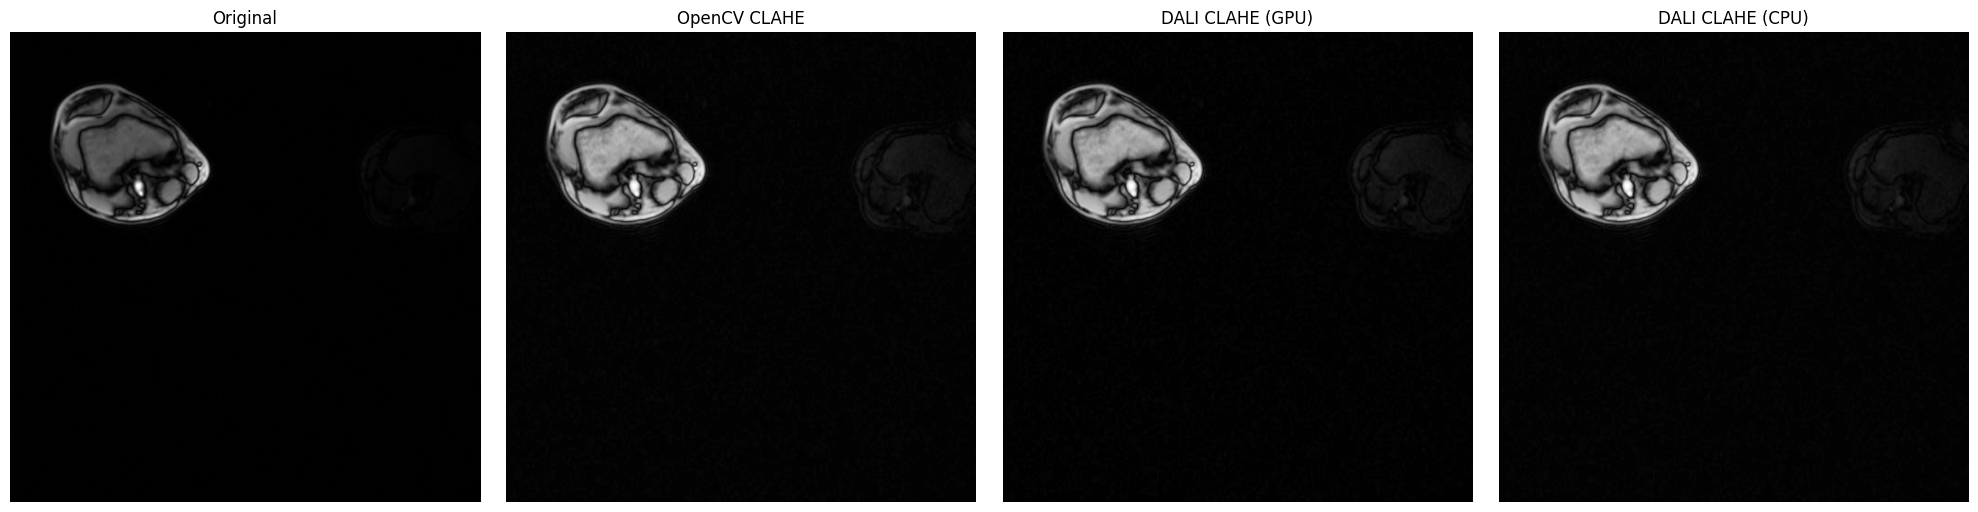


Implementation Comparison Metrics:
OpenCV vs DALI GPU:  MSE = 0.9326, MAE = 0.9325
OpenCV vs DALI CPU:  MSE = 0.0000, MAE = 0.0000
DALI GPU vs CPU:     MSE = 0.9326, MAE = 0.9325

Note: Lower values indicate closer agreement between implementations.


In [6]:
# CLAHE Processing: OpenCV and DALI
tiles_x, tiles_y, clip_limit = 8, 8, 2.0

# OpenCV CLAHE
opencv_result = apply_opencv_clahe(mri_array, tiles_x, tiles_y, clip_limit)

# DALI CLAHE GPU
dali_gpu_np = apply_dali_clahe(
    mri_array, tiles_x, tiles_y, clip_limit, luma_only=False, device="gpu"
)

# DALI CLAHE CPU
dali_cpu_np = apply_dali_clahe(
    mri_array, tiles_x, tiles_y, clip_limit, luma_only=False, device="cpu"
)

# Calculate metrics
opencv_flat = opencv_result.squeeze()
dali_gpu_flat = dali_gpu_np.squeeze()
dali_cpu_flat = dali_cpu_np.squeeze()

mse_ocv_gpu, mae_ocv_gpu = calculate_metrics(opencv_flat, dali_gpu_flat)
mse_ocv_cpu, mae_ocv_cpu = calculate_metrics(opencv_flat, dali_cpu_flat)
mse_gpu_cpu, mae_gpu_cpu = calculate_metrics(dali_gpu_flat, dali_cpu_flat)

# Show results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(mri_array.squeeze(), cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(opencv_result.squeeze(), cmap="gray")
axes[1].set_title("OpenCV CLAHE")
axes[1].axis("off")
axes[2].imshow(dali_gpu_flat, cmap="gray")
axes[2].set_title("DALI CLAHE (GPU)")
axes[2].axis("off")
axes[3].imshow(dali_cpu_flat, cmap="gray")
axes[3].set_title("DALI CLAHE (CPU)")
axes[3].axis("off")
plt.tight_layout()
plt.show()

print("\nImplementation Comparison Metrics:")
print("=" * 60)
print(f"OpenCV vs DALI GPU:  MSE = {mse_ocv_gpu:.4f}, MAE = {mae_ocv_gpu:.4f}")
print(f"OpenCV vs DALI CPU:  MSE = {mse_ocv_cpu:.4f}, MAE = {mae_ocv_cpu:.4f}")
print(f"DALI GPU vs CPU:     MSE = {mse_gpu_cpu:.4f}, MAE = {mae_gpu_cpu:.4f}")
print("\nNote: Lower values indicate closer agreement between implementations.")

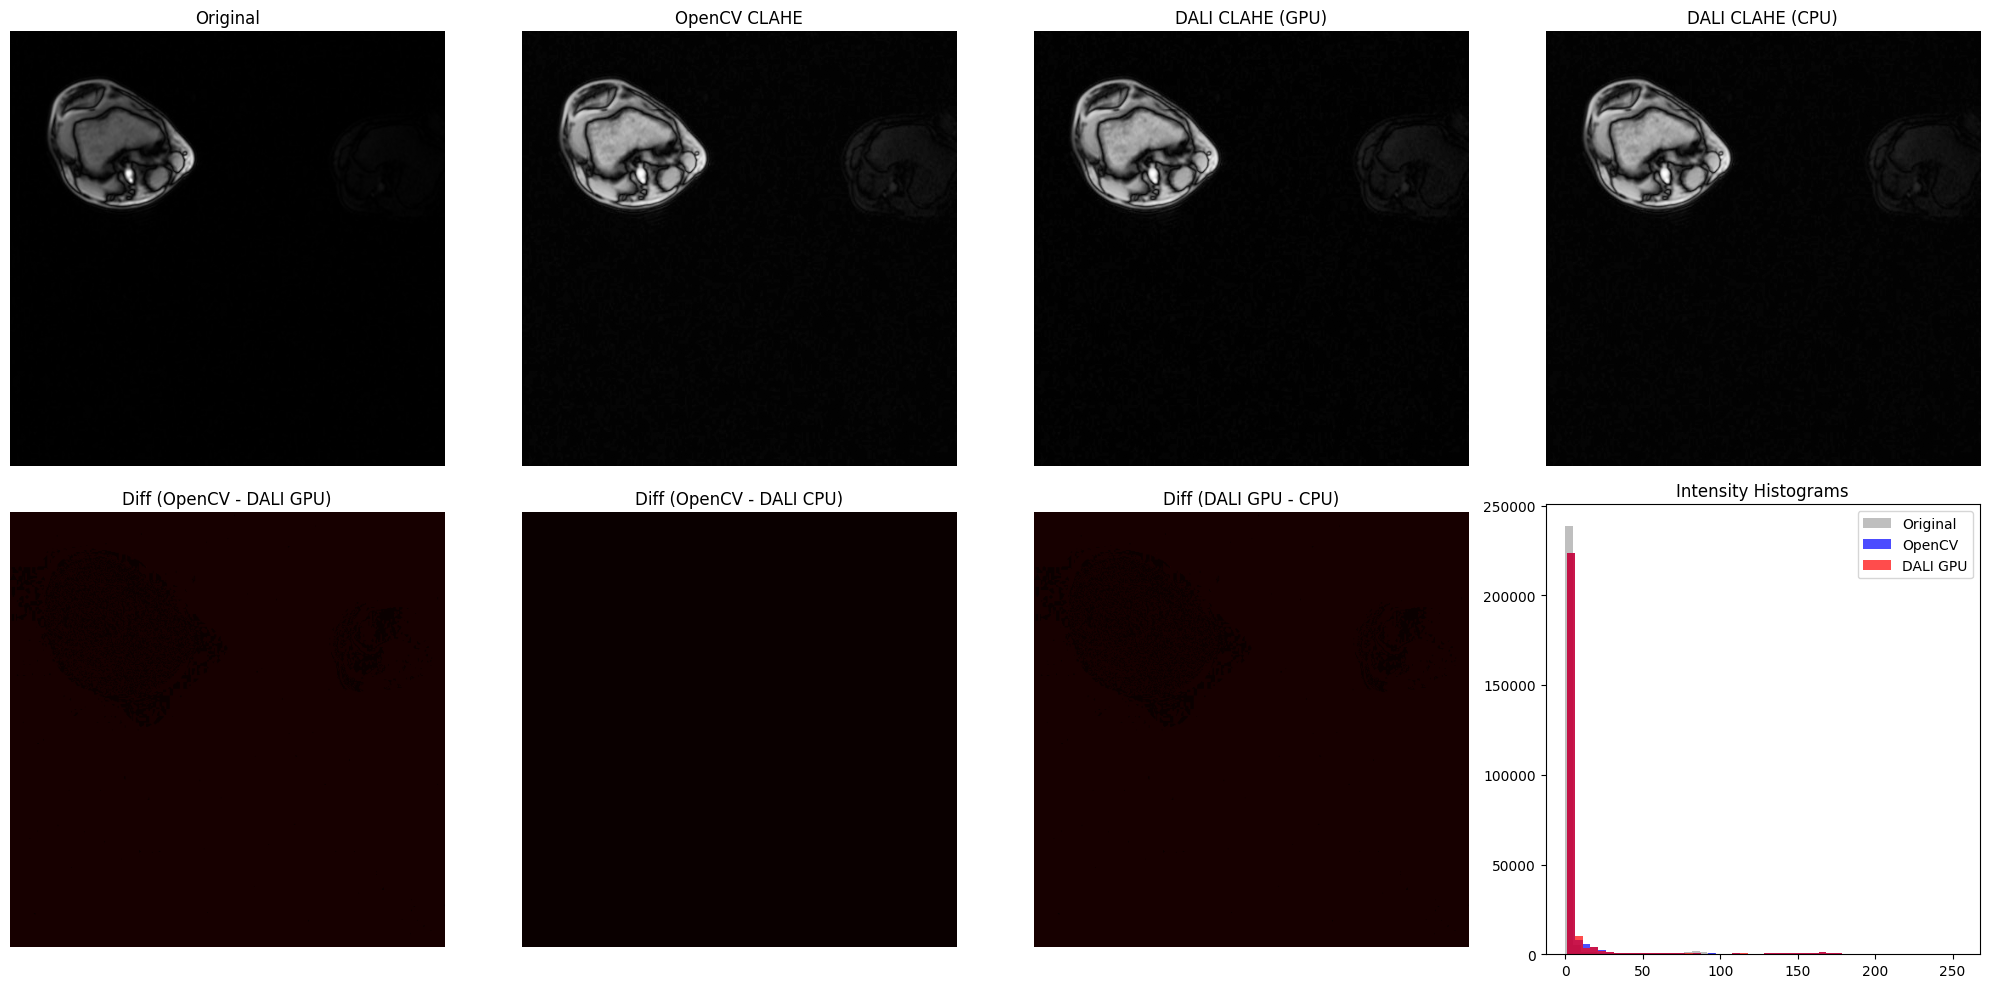

In [7]:
# Difference Maps and Intensity Histograms
diff_opencv_dali_gpu = np.abs(
    opencv_result.astype(float) - dali_gpu_np.astype(float)
)
diff_opencv_dali_cpu = np.abs(
    opencv_result.astype(float) - dali_cpu_np.astype(float)
)
diff_dali_gpu_cpu = np.abs(
    dali_gpu_np.astype(float) - dali_cpu_np.astype(float)
)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Top row: images
axes[0, 0].imshow(mri_array.squeeze(), cmap="gray")
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")
axes[0, 1].imshow(opencv_result.squeeze(), cmap="gray")
axes[0, 1].set_title("OpenCV CLAHE")
axes[0, 1].axis("off")
axes[0, 2].imshow(dali_gpu_flat, cmap="gray")
axes[0, 2].set_title("DALI CLAHE (GPU)")
axes[0, 2].axis("off")
axes[0, 3].imshow(dali_cpu_flat, cmap="gray")
axes[0, 3].set_title("DALI CLAHE (CPU)")
axes[0, 3].axis("off")

# Bottom row: difference maps and histogram
axes[1, 0].imshow(diff_opencv_dali_gpu.squeeze(), cmap="hot", vmin=0, vmax=50)
axes[1, 0].set_title("Diff (OpenCV - DALI GPU)")
axes[1, 0].axis("off")
axes[1, 1].imshow(diff_opencv_dali_cpu.squeeze(), cmap="hot", vmin=0, vmax=50)
axes[1, 1].set_title("Diff (OpenCV - DALI CPU)")
axes[1, 1].axis("off")
axes[1, 2].imshow(diff_dali_gpu_cpu.squeeze(), cmap="hot", vmin=0, vmax=50)
axes[1, 2].set_title("Diff (DALI GPU - CPU)")
axes[1, 2].axis("off")

# Intensity histograms
axes[1, 3].hist(
    mri_array.ravel(), bins=50, alpha=0.5, color="gray", label="Original"
)
axes[1, 3].hist(
    opencv_result.ravel(), bins=50, alpha=0.7, color="blue", label="OpenCV"
)
axes[1, 3].hist(
    dali_gpu_np.ravel(), bins=50, alpha=0.7, color="red", label="DALI GPU"
)
axes[1, 3].set_title("Intensity Histograms")
axes[1, 3].legend()

plt.tight_layout()

### Understanding CLAHE's Effect on Medical Images
Let's analyze how CLAHE transforms the intensity distribution of MRI data, which helps understand why it's so effective for medical imaging.

Analysis complete!

Key Insight for Medical Imaging:
   CLAHE adaptively enhances local contrast in each tissue region,
   making it ideal for MRI where different tissues have overlapping
   intensity ranges but important local boundaries.


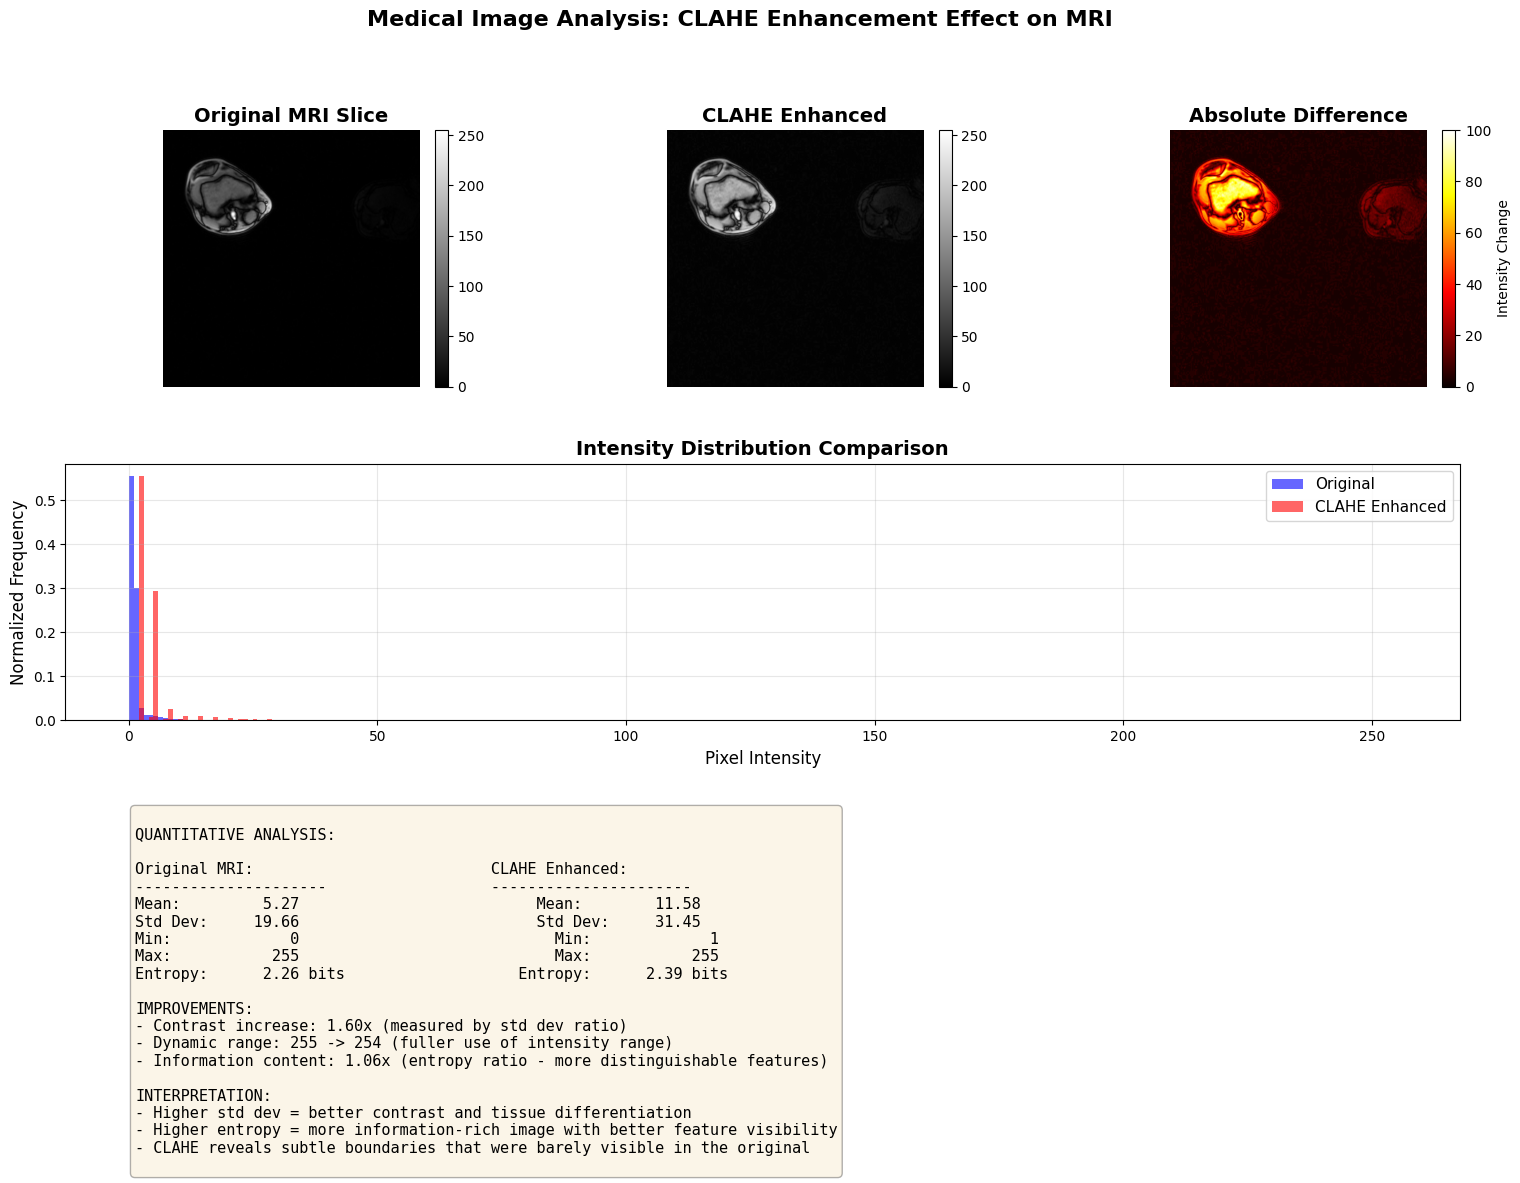

In [8]:
# Histogram Analysis for Medical Imaging
orig_slice = mri_array.squeeze()
clahe_slice = dali_gpu_flat

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(orig_slice, cmap="gray", vmin=0, vmax=255)
ax1.set_title("Original MRI Slice", fontsize=14, fontweight="bold")
ax1.axis("off")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(clahe_slice, cmap="gray", vmin=0, vmax=255)
ax2.set_title("CLAHE Enhanced", fontsize=14, fontweight="bold")
ax2.axis("off")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

ax3 = fig.add_subplot(gs[0, 2])
diff = np.abs(clahe_slice.astype(float) - orig_slice.astype(float))
im3 = ax3.imshow(diff, cmap="hot", vmin=0, vmax=100)
ax3.set_title("Absolute Difference", fontsize=14, fontweight="bold")
ax3.axis("off")
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label="Intensity Change")

# Row 2: Histograms
ax4 = fig.add_subplot(gs[1, :])
ax4.hist(
    orig_slice.ravel(),
    bins=256,
    alpha=0.6,
    color="blue",
    label="Original",
    range=(0, 255),
    density=True,
)
ax4.hist(
    clahe_slice.ravel(),
    bins=256,
    alpha=0.6,
    color="red",
    label="CLAHE Enhanced",
    range=(0, 255),
    density=True,
)
ax4.set_xlabel("Pixel Intensity", fontsize=12)
ax4.set_ylabel("Normalized Frequency", fontsize=12)
ax4.set_title(
    "Intensity Distribution Comparison", fontsize=14, fontweight="bold"
)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

# Row 3: Statistics
ax5 = fig.add_subplot(gs[2, :])
ax5.axis("off")

# Calculate statistics
orig_mean, orig_std = orig_slice.mean(), orig_slice.std()
orig_min, orig_max = orig_slice.min(), orig_slice.max()
clahe_mean, clahe_std = clahe_slice.mean(), clahe_slice.std()
clahe_min, clahe_max = clahe_slice.min(), clahe_slice.max()

# Calculate entropy
orig_hist, _ = np.histogram(
    orig_slice.ravel(), bins=256, range=(0, 255), density=True
)
clahe_hist, _ = np.histogram(
    clahe_slice.ravel(), bins=256, range=(0, 255), density=True
)
orig_entropy = -np.sum(orig_hist * np.log2(orig_hist + 1e-10))
clahe_entropy = -np.sum(clahe_hist * np.log2(clahe_hist + 1e-10))

stats_text = f"""
QUANTITATIVE ANALYSIS:

Original MRI:                          CLAHE Enhanced:
---------------------                  ----------------------
Mean:       {orig_mean:6.2f}                          Mean:       {clahe_mean:6.2f}
Std Dev:    {orig_std:6.2f}                          Std Dev:    {clahe_std:6.2f}
Min:        {orig_min:6.0f}                            Min:        {clahe_min:6.0f}
Max:        {orig_max:6.0f}                            Max:        {clahe_max:6.0f}
Entropy:    {orig_entropy:6.2f} bits                   Entropy:    {clahe_entropy:6.2f} bits

IMPROVEMENTS:
- Contrast increase: {(clahe_std/orig_std):.2f}x (measured by std dev ratio)
- Dynamic range: {orig_max-orig_min:.0f} -> {clahe_max-clahe_min:.0f} (fuller use of intensity range)
- Information content: {(clahe_entropy/orig_entropy):.2f}x (entropy ratio - more distinguishable features)

INTERPRETATION:
- Higher std dev = better contrast and tissue differentiation
- Higher entropy = more information-rich image with better feature visibility
- CLAHE reveals subtle boundaries that were barely visible in the original
"""

ax5.text(
    0.05,
    0.95,
    stats_text,
    transform=ax5.transAxes,
    fontsize=11,
    verticalalignment="top",
    fontfamily="monospace",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.3),
)

plt.suptitle(
    "Medical Image Analysis: CLAHE Enhancement Effect on MRI",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)

print("Analysis complete!")
print("\nKey Insight for Medical Imaging:")
print("   CLAHE adaptively enhances local contrast in each tissue region,")
print("   making it ideal for MRI where different tissues have overlapping")
print("   intensity ranges but important local boundaries.")

## Batch Processing MRI Slices
Let's demonstrate a more realistic medical imaging workflow: processing **multiple MRI slices in batch**. This showcases DALI's strength in efficient batch processing with GPU acceleration.

> **Try it yourself:** This cell processes multiple MRI slices simultaneously, demonstrating the power of batched CLAHE processing.

Processing 4 MRI slices in batch using NumPy reader...


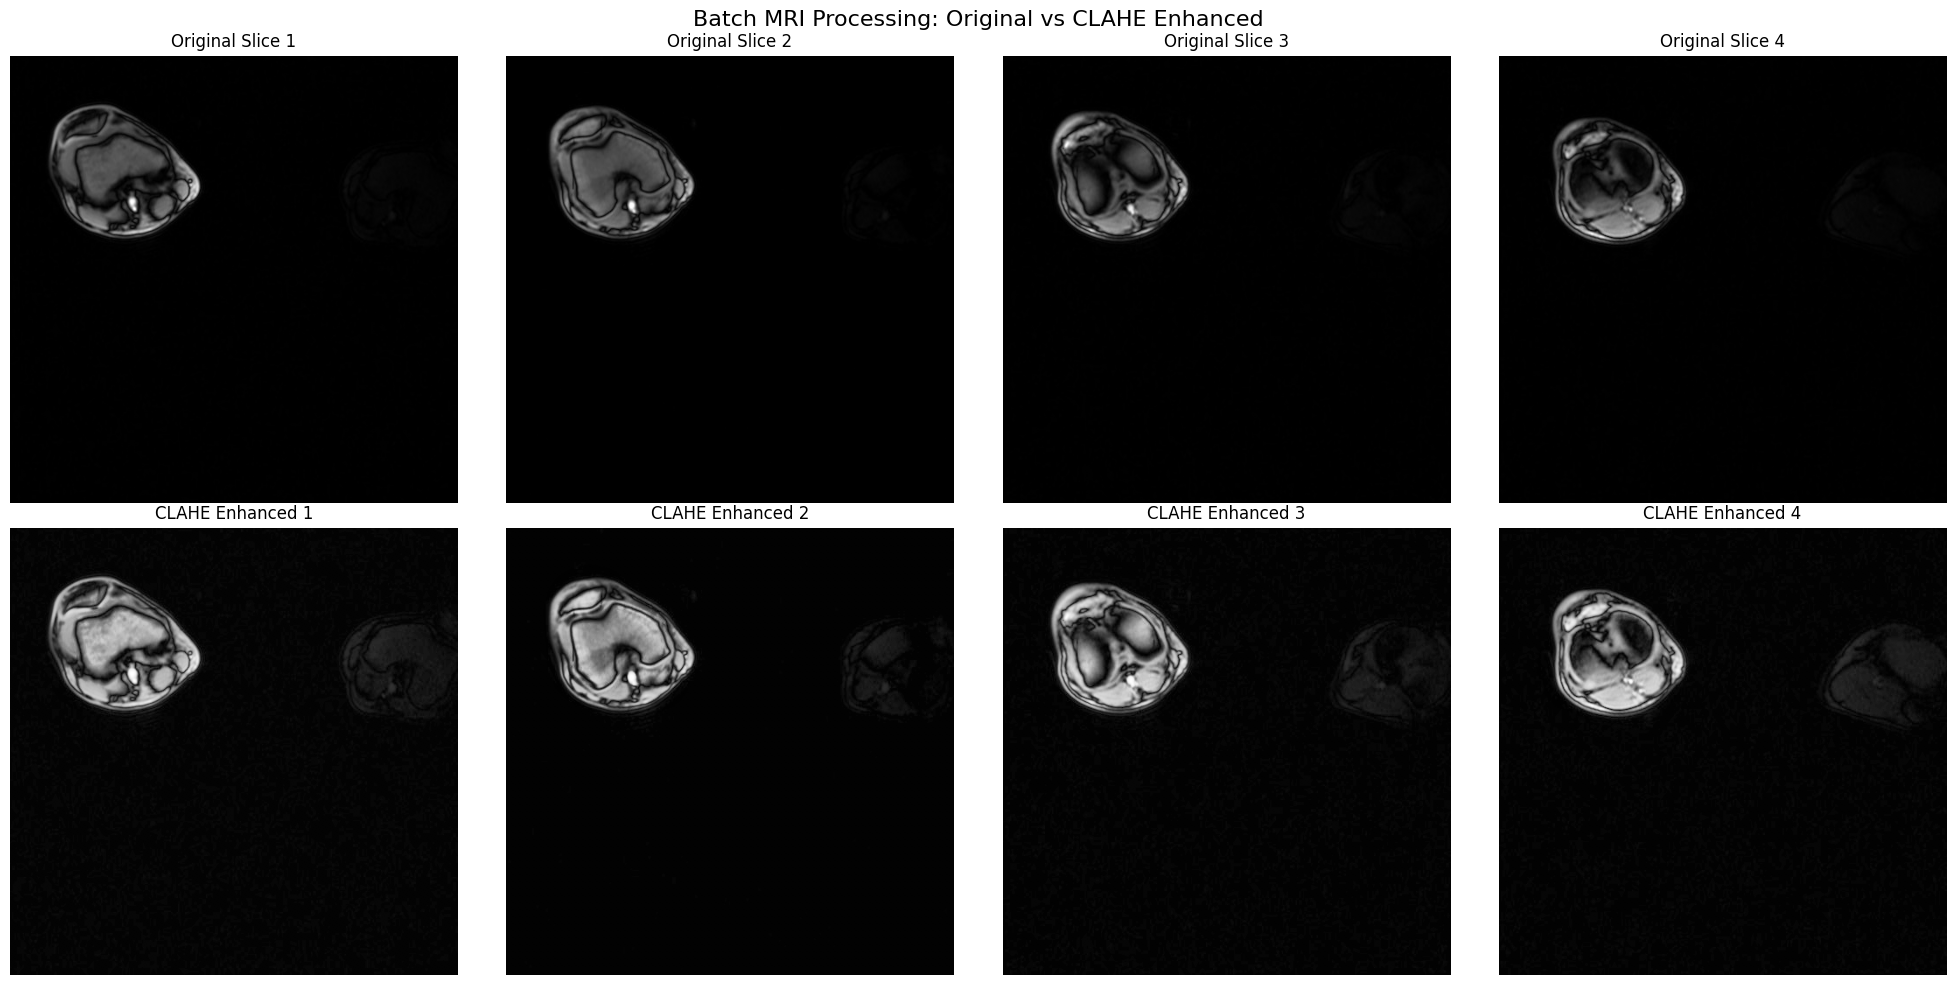


Contrast Improvement Analysis:
Slice 1:
  Original std: 19.7, Enhanced std: 33.4
  Contrast improvement: 1.70x

Slice 2:
  Original std: 20.1, Enhanced std: 33.1
  Contrast improvement: 1.65x

Slice 3:
  Original std: 18.3, Enhanced std: 31.5
  Contrast improvement: 1.73x

Slice 4:
  Original std: 17.6, Enhanced std: 29.7
  Contrast improvement: 1.69x

Batch processing complete!


In [9]:
batch_size = 4
print(f"Processing {batch_size} MRI slices in batch using NumPy reader...")

reader = ndd.readers.Numpy(file_root=str(mri_path), random_shuffle=False)

for (mri_batch,) in reader.next_epoch(batch_size=batch_size):
    break

# Add channel dimension and move to GPU
slices_with_channel = [
    np.expand_dims(np.asarray(mri_batch.select(i)), axis=-1)
    for i in range(batch_size)
]
mri_batch = ndd.as_batch(slices_with_channel, device="gpu")
clahe_batch = ndd.clahe(
    mri_batch, tiles_x=8, tiles_y=8, clip_limit=3.0, luma_only=False
)

fig, axes = plt.subplots(2, batch_size, figsize=(5 * batch_size, 10))

for i in range(batch_size):
    original = np.asarray(mri_batch.select(i).cpu()).squeeze()
    enhanced = np.asarray(clahe_batch.select(i).cpu()).squeeze()

    original = (
        (original - original.min()) / (original.max() - original.min()) * 255
    ).astype(np.uint8)
    enhanced = (
        (enhanced - enhanced.min()) / (enhanced.max() - enhanced.min()) * 255
    ).astype(np.uint8)

    axes[0, i].imshow(original, cmap="gray", vmin=0, vmax=255)
    axes[0, i].set_title(f"Original Slice {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(enhanced, cmap="gray", vmin=0, vmax=255)
    axes[1, i].set_title(f"CLAHE Enhanced {i+1}")
    axes[1, i].axis("off")

plt.suptitle(
    "Batch MRI Processing: Original vs CLAHE Enhanced", fontsize=16, y=0.98
)
plt.tight_layout()
plt.show()

print("\nContrast Improvement Analysis:")
print("=" * 60)
for i in range(batch_size):
    original = np.asarray(mri_batch.select(i).cpu()).squeeze()
    enhanced = np.asarray(clahe_batch.select(i).cpu()).squeeze()
    orig_std = np.std(original)
    clahe_std = np.std(enhanced)
    improvement = clahe_std / orig_std if orig_std > 0 else 1.0

    print(f"Slice {i+1}:")
    print(f"  Original std: {orig_std:.1f}, Enhanced std: {clahe_std:.1f}")
    print(f"  Contrast improvement: {improvement:.2f}x")
    print()

print("Batch processing complete!")

## CLAHE on Color Images: WebP Example
Now let's demonstrate CLAHE on a **color photograph** using a WebP image from DALI_extra. 

**Important:** DALI's GPU CLAHE only supports `luma_only=True` (the default), which processes the luminance channel in LAB color space. This is the recommended approach for RGB images as it:
- Preserves natural color relationships
- Produces visually superior results
- Matches OpenCV's LAB-based CLAHE behavior
- Runs efficiently on GPU

If you need per-channel RGB processing (`luma_only=False`), you must use the CPU operator.

Make sure you use RGB channel order for DALI CLAHE. OpenCV's default is BGR channel order.

The cat image (`db/single/webp/lossy/cat-3591348_640.webp`) is perfect for demonstrating:
- **RGB processing**: Standard web image format (3-channel RGB)
- **Natural scenes**: Real-world photography with varying lighting conditions
- **Luminance-based enhancement**: How CLAHE improves contrast while preserving colors

In [10]:
# Configuration for color image CLAHE processing
# Set USE_LUMA_ONLY to control how CLAHE processes color images:
#
# True (default): Process only luminance in LAB color space
#        - Preserves color relationships better
#        - More natural-looking results for color images
#        - Supported on both GPU and CPU
#        - GPU ONLY supports this mode
#
# False: Process each RGB channel independently
#        - Enhances contrast in each channel separately
#        - Can introduce color shifts
#        - ONLY works with DALI CPU operator (not supported on GPU)
#
USE_LUMA_ONLY = True

### Understanding Implementation Differences

**GPU vs CPU CLAHE Support:**

The GPU implementation only supports `luma_only=True` (the default), which processes the luminance channel in LAB color space. This is the recommended mode for RGB images as it preserves color relationships.

**When to use each setting:**
- **`USE_LUMA_ONLY = True`** (default, GPU-supported): Processes luminance in LAB color space
  - GPU-accelerated (fast!)
  - Works on both GPU and CPU
  - Preserves color relationships better
  - More natural-looking results for photographs
  - OpenCV and DALI produce nearly identical results
  
- **`USE_LUMA_ONLY = False`**: Processes RGB channels independently
  - CPU ONLY - GPU does not support this mode
  - Good for specific use cases requiring per-channel enhancement
  - May introduce color artifacts
  - Slower (CPU-only)

**Why the difference?**
The GPU implementation prioritizes the most common and visually superior mode (`luma_only=True`) for optimal performance. Per-channel RGB processing would require extracting and processing each channel separately, which is less efficient and produces inferior results for most applications.

> **Try it yourself**: Change `USE_LUMA_ONLY` above and re-run the next cell to see the difference! Note that setting it to False will use CPU processing.

In [11]:
# Load cat image from DALI_extra
cat_image_path = (
    dali_extra_path
    / "db"
    / "single"
    / "webp"
    / "lossy"
    / "cat-3591348_640.webp"
)

print(f"Loading cat image from DALI_extra...")
print(f"Path: {cat_image_path}")

# Load and convert to RGB
cat_bgr = cv2.imread(str(cat_image_path))
cat_rgb = cv2.cvtColor(cat_bgr, cv2.COLOR_BGR2RGB)

print(f"Image loaded: shape={cat_rgb.shape}, dtype={cat_rgb.dtype}")
print(f"Value range: [{cat_rgb.min()}, {cat_rgb.max()}]")

Loading cat image from DALI_extra...
Path: /localhome/local-rtabet/Documents/DALI_extra/db/single/webp/lossy/cat-3591348_640.webp
Image loaded: shape=(427, 640, 3), dtype=uint8
Value range: [0, 255]


In [12]:
tiles_x, tiles_y, clip_limit = 8, 8, 2.0

print(f"Applying OpenCV CLAHE (luma_only={USE_LUMA_ONLY})...")
opencv_clahe_rgb = apply_opencv_clahe(
    cat_rgb, tiles_x, tiles_y, clip_limit, luma_only=USE_LUMA_ONLY
)

device_to_use = "gpu" if USE_LUMA_ONLY else "cpu"
print(
    f"Applying DALI {device_to_use.upper()} CLAHE (luma_only={USE_LUMA_ONLY})..."
)

dali_clahe_rgb = apply_dali_clahe(
    cat_rgb,
    tiles_x,
    tiles_y,
    clip_limit,
    luma_only=USE_LUMA_ONLY,
    device=device_to_use,
)

mse_ocv_dali, mae_ocv_dali = calculate_metrics(opencv_clahe_rgb, dali_clahe_rgb)

Applying OpenCV CLAHE (luma_only=True)...
Applying DALI GPU CLAHE (luma_only=True)...



COLOR IMAGE CLAHE COMPARISON (luma_only=True)
OpenCV vs DALI GPU:  MSE = 11.0366, MAE = 2.3678

Image Statistics:
Original       - Mean: 88.1, Std: 63.6
OpenCV         - Mean: 103.3, Std: 67.4


DALI GPU    - Mean: 102.3, Std: 67.1

Contrast Improvement:
OpenCV:        1.06x
DALI GPU    1.05x

Note: With luma_only=True, CLAHE processes only the luminance channel in LAB color space.
This preserves color relationships and produces more natural-looking results.


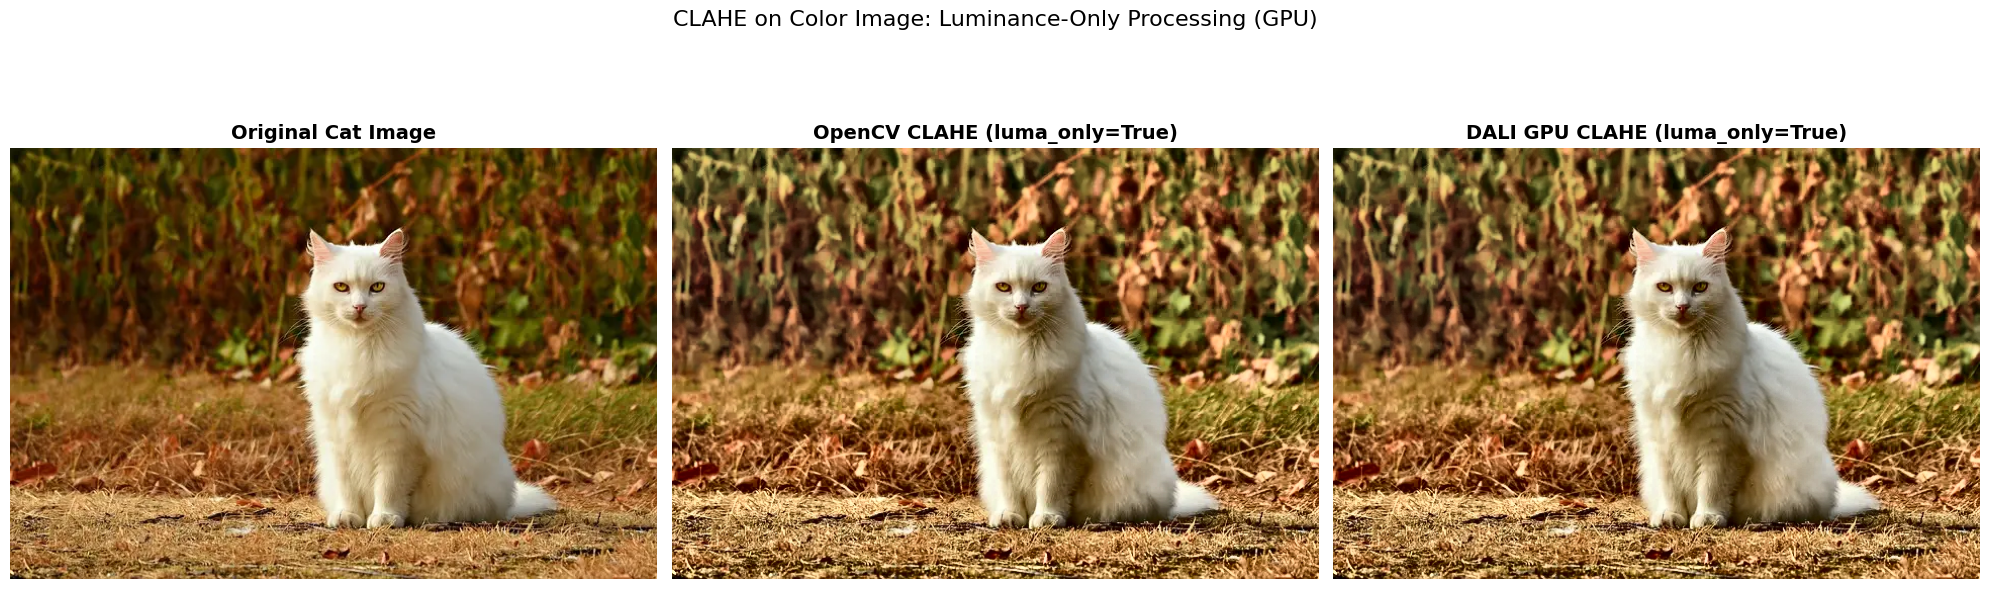

In [13]:
# Display results
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

axes[0].imshow(cat_rgb)
axes[0].set_title("Original Cat Image", fontsize=14, fontweight="bold")
axes[0].axis("off")

axes[1].imshow(opencv_clahe_rgb)
axes[1].set_title(
    f"OpenCV CLAHE (luma_only={USE_LUMA_ONLY})", fontsize=14, fontweight="bold"
)
axes[1].axis("off")

axes[2].imshow(dali_clahe_rgb)
axes[2].set_title(
    f"DALI {device_to_use.upper()} CLAHE (luma_only={USE_LUMA_ONLY})",
    fontsize=14,
    fontweight="bold",
)
axes[2].axis("off")

processing_type = (
    "Luminance-Only Processing (GPU)"
    if USE_LUMA_ONLY
    else "Per-Channel Processing (CPU)"
)
plt.suptitle(f"CLAHE on Color Image: {processing_type}", fontsize=16, y=0.98)
plt.tight_layout()

# Print comparison metrics
print("\n" + "=" * 60)
print(f"COLOR IMAGE CLAHE COMPARISON (luma_only={USE_LUMA_ONLY})")
print("=" * 60)
print(
    f"OpenCV vs DALI {device_to_use.upper()}:  MSE = {mse_ocv_dali:.4f}, MAE = {mae_ocv_dali:.4f}"
)
print("\nImage Statistics:")
print(f"Original       - Mean: {cat_rgb.mean():.1f}, Std: {cat_rgb.std():.1f}")
print(
    f"OpenCV         - Mean: {opencv_clahe_rgb.mean():.1f}, Std: {opencv_clahe_rgb.std():.1f}"
)
print(
    f"DALI {device_to_use.upper():6} - Mean: {dali_clahe_rgb.mean():.1f}, Std: {dali_clahe_rgb.std():.1f}"
)

contrast_orig = cat_rgb.std()
contrast_opencv = opencv_clahe_rgb.std()
contrast_dali = dali_clahe_rgb.std()

print(f"\nContrast Improvement:")
print(f"OpenCV:        {contrast_opencv/contrast_orig:.2f}x")
print(f"DALI {device_to_use.upper():6} {contrast_dali/contrast_orig:.2f}x")

print(
    "\nNote: With luma_only=True, CLAHE processes only the luminance channel in LAB color space."
)
print(
    "This preserves color relationships and produces more natural-looking results."
)

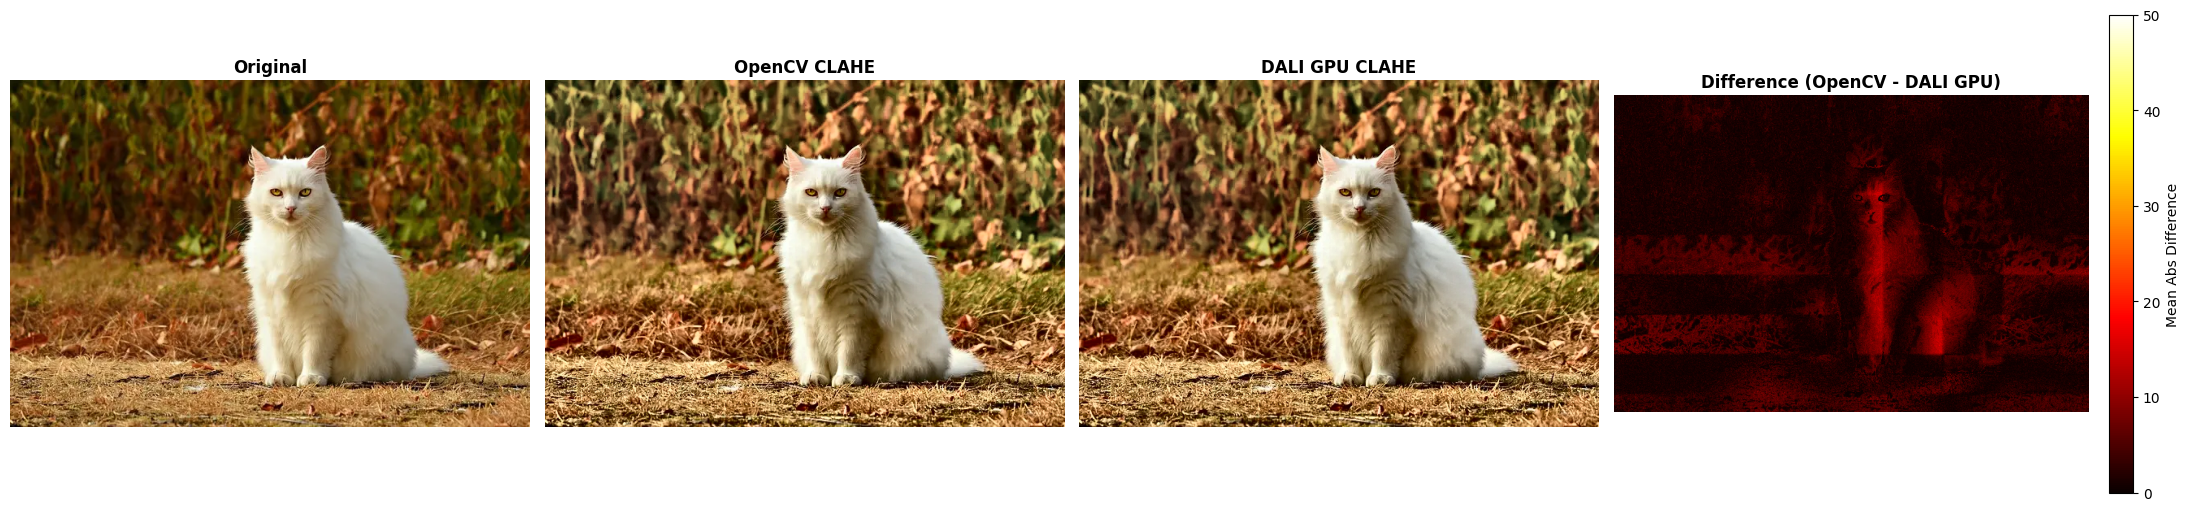

In [14]:
# Show difference map for color image
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

axes[0].imshow(cat_rgb)
axes[0].set_title("Original", fontsize=12, fontweight="bold")
axes[0].axis("off")

axes[1].imshow(opencv_clahe_rgb)
axes[1].set_title("OpenCV CLAHE", fontsize=12, fontweight="bold")
axes[1].axis("off")

axes[2].imshow(dali_clahe_rgb)
axes[2].set_title(
    f"DALI {device_to_use.upper()} CLAHE", fontsize=12, fontweight="bold"
)
axes[2].axis("off")

# Difference map between OpenCV and DALI
diff_rgb = np.abs(opencv_clahe_rgb.astype(float) - dali_clahe_rgb.astype(float))
diff_rgb_display = np.mean(diff_rgb, axis=2)  # Average across RGB channels
im = axes[3].imshow(diff_rgb_display, cmap="hot", vmin=0, vmax=50)
axes[3].set_title(
    f"Difference (OpenCV - DALI {device_to_use.upper()})",
    fontsize=12,
    fontweight="bold",
)
axes[3].axis("off")
plt.colorbar(
    im, ax=axes[3], fraction=0.046, pad=0.04, label="Mean Abs Difference"
)

plt.tight_layout()
plt.show()